<a href="https://colab.research.google.com/github/MausamArora/LandMapRegularization/blob/main/Training_Land_Cover_Classification_using_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Land Use and Cover Classification using Convolutional Neural Networks (CNNs)

## Introduction

Land use describes the use of land surfaces by humans. Land cover describes physical features that occupy the surface of the Earth, such as water, forest, urban structures, vegetation, etc.

We rely on accurate land use data for both scientific and administrative purposes. In particular, land cover and land use data are critical to achieve sustainable urban development. For example, land use information can be used to ensure that residential neighborhoods are positioned close to commercial centers and transportation services, and far from industrial areas. Land use data is also an important components of climatic and hydrologic modelling such as estimating the runoff of rainfall from varied surfaces into stream systems.

While it is possible to acquire land use and land cover data through direct observation by visiting each site in person, this process can be costly and time consuming. A more efficient approach is to use satellite imagery and machine learning to automate the process.

In this tutorial, we will develop and evaluate a deep learning machine learning (ML) model to automatically classify land cover types from satellite imagery. Specifically, we will achieve the following:   

1. Download the EuroSAT dataset from the TensorFlow Datasets platform for training our model
2. Clean and prepare the EuroSAT dataset to feed into a deep ML model
3. Split the cleaned data into training and test sets
4. Define and build a convolutional neutral network (a type of deep learning) using the Keras framework
5. Fit the model to our training data
6. Evaluate the accuracy of our model on the test set using visualisation techniques
7. Use the model to make predictions on a new image

## Dataset
In this tutorial, we will be using the EuroSAT dataset to train and evaluate our deep neural network.

The EuroSAT dataset is a novel dataset based on Sentinel-2 images containing 27,000 labeled images with 10 different land use and land cover classes. A unique characteristic of the EuroSAT dataset is that it is multi-spectral covering 13 spectral bands in the visible, near infrared and short wave infrared part of the spectrum.

The dataset was constructed in the following two steps:
1. Sentinel-2A satellite images were gathered from  European cities in over 34 countries;
2. Based on the gathered satellite images, a dataset of 27,000 geo-referenced and labeled 64x64 pixels image patches was created.

For more information, refer to the official paper: [EuroSAT : Land Use and Land Cover Classification with Sentinel-2](https://github.com/phelber/eurosat)


## TensorFlow and Keras

This tutorial will be using TensorFlow and Keras to build a deep convolutional neural network to classify land cover and land use.

TensorFlow is a Python-based, free, open source machine learning platform, developed primarily by Google. Much like NumPy, the primary purpose of TensorFlow is to enable engineers and researchers to manipulate mathematical expressions over numerical tensors.

Keras is a deep learning API for Python, built on top of TensorFlow, that provides a convenient way to define and train any kind of deep learning model. Keras was initially developed for research, with the aim of enabling fast deep learning experimentation.

Through TensorFlow, Keras can run on top of different types of hardware including GPU, TPU, or CPU and can be seamlessly scaled to thousands of machines.

Let's begin ...

### Mount Google Drive

Mounting your Google Drive in the runtime's virtual machine allows you to write and to read files from your Google Drive through this notebook. Later in the tutorial, once we have trained our model, we will be saving the trained model to our Google Drive to be able to load at a later time without having to train the model all over again.

To mount your Google Drive, run the following two lines:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Run the helper function notebook so we use the functions in this notebook

In [ ]:
%run /content/drive/MyDrive/Colab\ Notebooks/Helper\ Functions\ -\ Land\ Cover\ Classification.ipynb

### Import libraries

In [ ]:
import tensorflow as tf #import tensorflow library
import tensorflow_datasets as tfds #import tensorflow datasets

import matplotlib.pyplot as plt #import matplotlib for plotting
import numpy as np # import numpy
import random # import the random package for random number generation

### Download the EuroSAT dataset

In [ ]:
ds = tfds.load( #loads the named dataset into a `tf.data.Dataset`
    'eurosat/all', # specifies the eurosat dataset with 13 Sentinel-2 channels to download. 'eurosat/rgb' is also available which only downloads the 3 rgb channels for each image.
    split='train[:35%]', # download only 35% of the 27,000 available images due to memory constraints
    shuffle_files = True,
    as_supervised=True, # download in a 2-tuple structure (input, label)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/all/2.0.0.incomplete96ESPL/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/all/2.0.0. Subsequent calls will reuse this data.


### Load the `tf.data.Dataset` into a `numpy` tensors

The `tfds.load()` function above downloads the images into a `tf.data.Dataset` object. Before we can use and manipulate it, we first have to convert the `tf.data.Dataset` object to Numpy tensors.

Tensors are essentially containers for storing multidimensional data. Numpy arrays are also called Numpy tensors. In general, all current machine learning systems use tensors as their basic data structure. TensorFlow is named after tensors.



In [ ]:
images = [] #defines a Python list to store the images
labels = [] #defines a Python list to store the label of each image

for image, label in tfds.as_numpy(ds): #for each (image, label) in the `tf.data.Dataset`
    images.append(image) #add the image to the images list
    labels.append(label) #add the label to the labels list


images_arr = np.array(images) # convert the Python list to a numpy array
labels_arr = np.array(labels) # ditto


### Explore the data

As you can see below, the images array contains `9450` images, and each image is `64x64` pixels containing 13 spectral bands.

The labels array, on the other hand, contains `9450` labels but has only 1 column (the label classifying the class that an image belongs to)

In [ ]:
print(images_arr.shape)
print(labels_arr.shape)

(9450, 64, 64, 13)
(9450,)


Let's plot a *single* pixel of the first image from the dataset. Y-axis is the reflectance of the each band, and X-axis is the band number.

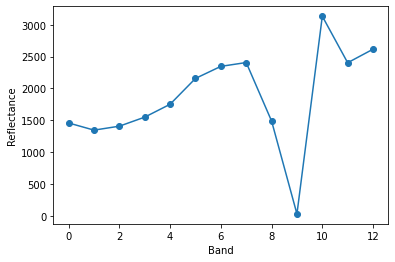

In [ ]:
plt.ylabel("Reflectance") #add a y-axis label
plt.xlabel('Band') # add an x-axis label
plt.plot(images_arr[1,30,30, :],'-o') # plot the reflectance values of all bands of the pixel at location (30,30) from the first image.

### Data preprocessing
Deep learning models do not work well with raw data. Data preprocessing aims at making the raw data more amenable to neural networks. One common preprocessing step is called One-Hot Encoding.

One-Hot Encoding is a widely used format for categorical data. In this case one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. Conceretly, consider the following:

Each image in our data belongs to one of 10 classes specifying the land cover type. For example, the label for image 123 is `7` (PermanentCrop). You can find the label for image 123 by running this code `labels_arr[123]`.

After one-hot encoding, we get a vector with 10 columns filled with 0s except for a single 1 at index 6 (label 7):   
`[0,0,0,0,0,0,1,0,0,0]`

In [ ]:
from sklearn.preprocessing import OneHotEncoder #import OneHotEncoder from sklearn

In [ ]:
enc = OneHotEncoder(sparse=False) #Define the OneHotEncoder
labels_onehot_encoded = enc.fit_transform(labels_arr.reshape(-1, 1)) #Fit OneHotEncoder to labels_arr, then transform labels_arr.
##the reshape(-1,1) simply reshapes our labels array to a single column (9450, 1) before feeding it to the fit_transform method

print(labels_onehot_encoded.shape) #print shape of one-hot-encoded labels array
print(images_arr.shape) #print shape of images_array


(9450, 10)
(9450, 64, 64, 13)


Another preprocessing step is normalising the image data which are currently encoded as integers. Normalisation is changing the values of a dataset to use a common scale, without distoring differences in the ranges of values or losing information.

To normalise our images before we fed them into our network, we have to cast it to `float32` and divide by the maximum so we’d end up with floating-point values in the 0–1 range.

In [ ]:
def normalise_images(images_array):
  image = images_arr.astype('float32') #create a new `float32` Numpy array
  for i in range(0, len(images_arr)):  # go through every image in the array
      amax_tmp=np.amax(images_arr[i,:,:,:]) # find the max value in each image
      image[i,:,:,:] = images_arr[i,:,:,:] / amax_tmp #divide every image value by the maximum and store in new Numpy Array

  return image

image = normalise_images(images_arr) #call the normalise_images function and pass the images we read from TensorFlow Datasets

Let’s display a few images we downloaded from TensorFlow Datasets, using the Matplotlib library (a well-known Python data visualization library, which comes preinstalled in Colab).

In [ ]:
def get_classlabel(class_code): #function to map integer values to human-readable labels
    labels = {0:'AnnualCrop', 1:'Forest', 2:'HerbaceousVegetation', 3:'Highway', 4:'Industrial', 5:'Pasture', 6:'PermanentCrop', 7:'Residential', 8:'River', 9:'SeaLake'}

    return labels[class_code]

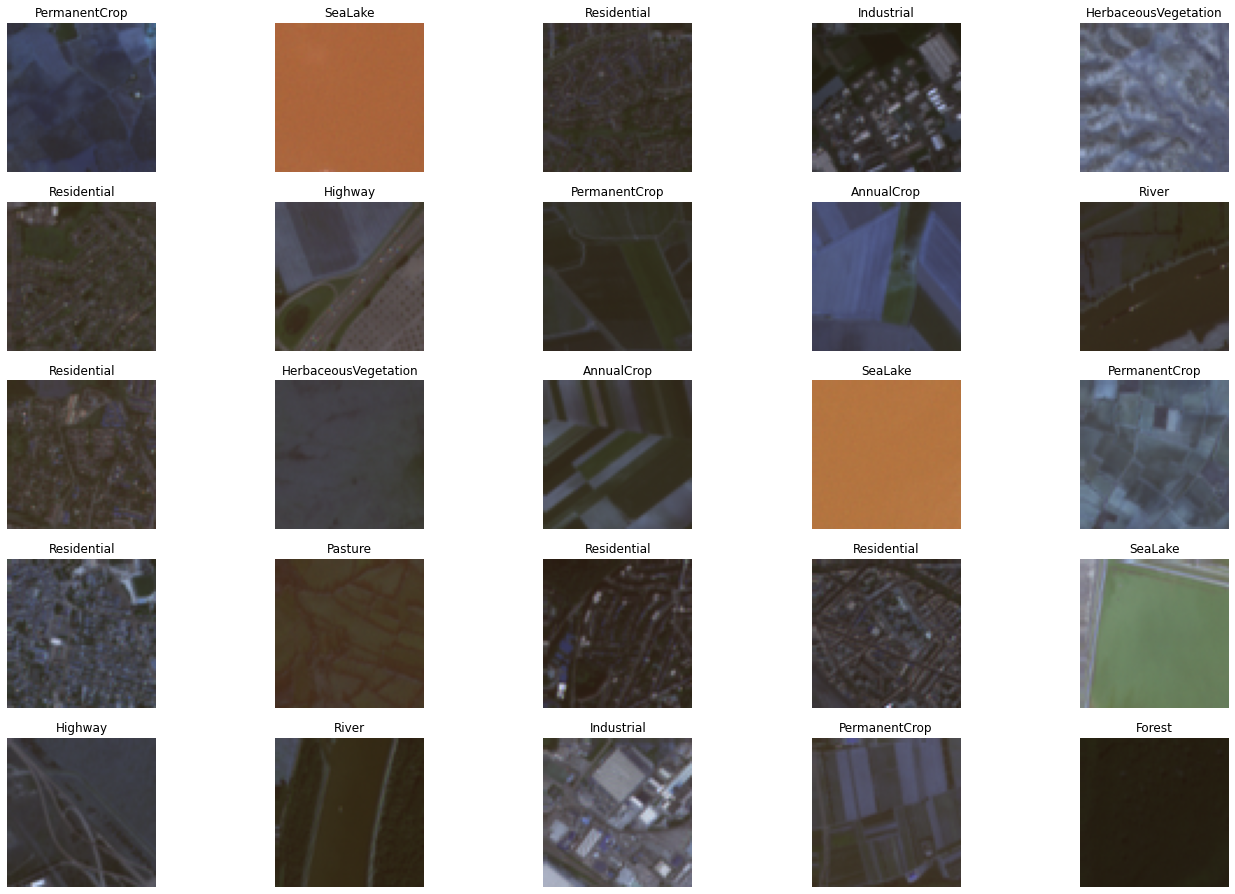

In [ ]:
"""
Function to plot images and labels
Input: images array, labels array
Output: None

"""
def plot_images(images_array, labels_array):
  fig,ax = plt.subplots(5,5) #instantite a figure with 5x5 subplots
  fig.subplots_adjust(0,0,3,3) # add some padding
  for i in range(0,5,1): # randomly select 5 images
      for j in range(0,5,1):
          rnd_number = random.randint(0,len(images_array))
          ax[i,j].imshow(images_array[rnd_number, :, :, 1:4])
          ax[i,j].set_title(get_classlabel(labels_array[rnd_number]))
          ax[i,j].axis('off')

plot_images(image, labels_arr)

### Training and Test Sets
Evaluating a model always boils down to splitting the available data into three sets: training, validation, and test. You train on the training data and evaluate your model on the validation data. Once you have optimised your model, you test it one final time on the test data. The test set should be as similar as possible to production data.

For brevity, in this tutorial, we are just going to split our data into two sets: training set and test set.

In [ ]:
"""
The Scikit-learn Python package comes with a handy function that splits arrays or matrices into random train and test subsets
"""
#import train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
"""
We are setting aside 20% of our data for the test set and using 80% for training the model.
Below, we call the train_test_split function on our normalised images array and our one-hot-encoded labels array, setting shuffle to True to shuffle the data before splitting,
and setting the random_state to 42 (can be any number) for reproducible output across multiple function calls
"""
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(image, labels_onehot_encoded, test_size = test_size, shuffle=True, random_state=42)

## Select and Train a Model

### Import Keras Libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


#### Define a Keras Sequential Model

The simplest way to build a Keras model is to use the Sequential model. Keras Sequential Model is simply a stack of layers that map a single input to a single output.


In [ ]:
#Initialise a Sequential Model
model = keras.Sequential()

Below we define our model's architecture. As discussed, a Sequential model is simply a stack of layers. This particular model is made up of four types of layers stacked on top of each other. Let's briefly go through each type of layer.

`Conv2D` – Image data, stored in rank-4 tensors, is usually processed by 2D convolution layers (Conv2D). This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. A convolution is the simple application of a filter to an input that results in an activation.

The `Conv2D` layer below takes five parameters:
- `filters` – integer, specifying the dimensionality of the output space. Filters detect spatial patterns such as edges in an image by detecting the changes in intensity values of the image
- `kernel_size` – an integer or a list of 2 integers, specifying the height and width of the 2D convolution window
- `activation` – activation function to use
- `padding` – either "valid" or "same". "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input.
- `input_shape` – the dimenstions of the input image.   

    
The `MaxPooling2D` layer is used to reduce the dimension of the image by taking the maximum value over an input window (of size defined by `pool_size`) for each channel of the input.   

The `MaxPooling2D` layer below takes one parameter, `pool_size` that defines the size of the input window.


The `Dense` layer is densely connected (also called fully connected) neural layers. This means these layers are connected to every unit in the previous layer. In the example below, the Dense layer takes two parameters:
- `units` – positive integer, dimensionality of the output space
- `activation` – activation function to use

Finally, the `Dropout` layer is a weight regularisation technique that is common to mitigate overfitting. This layer randomly ignores certain units during training. The percentage of units to ignore is specified by the `rate` parameter.


In [ ]:
"""
Here we define the architecture of our model.

In this specific example, we use four Conv2D layers, three MaxPooling2D layers, two dense layers and one Dropout layer for weight regularisation.
"""
_, num_classes = y_train.shape # get the dimensions (number samples and num classes) of the training labels

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

Here we specify the configurations of our model. In particular, we choose the `optimizer`, the `loss` function, and the `metric` we will use to evaluate our model.

In [ ]:
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6) #define an RMSprop optimiser with the specified learning rate and decay (decay of the learning rate over time)

model.compile(loss='categorical_crossentropy', # use categorical_crossentropy loss function, commoly used for multiclass, singlelabel classification
              optimizer=opt, # specify our optimiser we define above
              metrics=['accuracy']) # we will be using accuracy as our evaluation metric

model.summary() #print the content of our model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        3776      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       1

In [ ]:
"""
Here we define a callback list. A callback is an object (a class instance implementing specific methods)
that is passed to the model in the call to fit() and that is called by the model at various points during training.
It has access to all the available data about the state of the model and its performance,
and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model.

Below we define two callbacks:
1. EarlyStopping to interuppt training when the validation accuracy does not improve after four epochs (patience)
2. ModelCheckpoint to save the model at model that has the best validation loss (low validation loss)
"""
callbacks_list = [
  EarlyStopping(
      monitor='val_accuracy',
      patience=4,
  ),
  ModelCheckpoint(
      filepath='/content/drive/MyDrive/Colab Notebooks/LandCoverClassification/TrainedModel/land_cover_classification_pretrained.h5', #path in our GDrive to save model
      monitor='val_loss',
      save_best_only=True,
  )
]

We have done all the ground work to prepare our model for training. Now is the time to actually train our model on our training data. Training in Keras is done through the `.fit()` function. This function takes the following paramters:

- `X` – input data
- `y` – labels for the inpute data
- `epochs` – everytime the model sees the data, it learns something new and `epochs` define how many iterations to cycle through the training data.
- `batch_size` – the number of training samples to use for each gradient update. The higher the batch_size the more memory your require.
- `validation_data` – validation data to evaluate your model after each epoch
- `callbacks` – a list of callback functions
- `verbose` – 0 or 1. Verbosity mode. 0 = silent, 1 = progress bar.


In [ ]:
batch_size = 32
epochs = 50

history = model.fit(X_train, y_train, #train the model
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose = 1)

y_pred = model.predict(X_test) # make predictions on the test_set

Epoch 1/50
237/237 [==============================] - 35s 48ms/step - loss: 1.5062 - accuracy: 0.4397 - val_loss: 1.2342 - val_accuracy: 0.5413
Epoch 2/50
237/237 [==============================] - 8s 33ms/step - loss: 1.1133 - accuracy: 0.5902 - val_loss: 1.0947 - val_accuracy: 0.5804
Epoch 3/50
237/237 [==============================] - 8s 33ms/step - loss: 0.9450 - accuracy: 0.6607 - val_loss: 0.7758 - val_accuracy: 0.7153
Epoch 4/50
237/237 [==============================] - 8s 35ms/step - loss: 0.8280 - accuracy: 0.7017 - val_loss: 1.1180 - val_accuracy: 0.5614
Epoch 5/50
237/237 [==============================] - 8s 32ms/step - loss: 0.7528 - accuracy: 0.7299 - val_loss: 0.9168 - val_accuracy: 0.6545
Epoch 6/50
237/237 [==============================] - 8s 34ms/step - loss: 0.6893 - accuracy: 0.7548 - val_loss: 0.7732 - val_accuracy: 0.6947
Epoch 7/50
237/237 [==============================] - 8s 34ms/step - loss: 0.6410 - accuracy: 0.7737 - val_loss: 0.5394 - val_accuracy: 0.812

### Validating your model
Note above that the call to `model.fit()` returns a `History` object. This object has a member called `history`, which is a dictionary containing data about everything that happened during training. Below we retrieve the `loss` and `val_loss` the occured at each epoch and plot it using the `matplotlib` library.

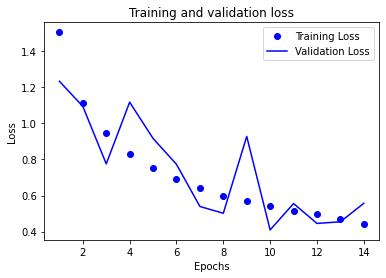

In [ ]:
history_dict = history.history #access the history attribute of the History object
loss_values = history_dict["loss"] #get the training loss values
val_loss_values = history_dict["val_loss"] # get the validation loss values
epochs = range(1, len(loss_values) +1) # specify number of epochs we want to visualise. In this example, all training epochs.
plt.plot(epochs, loss_values, "bo", label="Training Loss") #plot the training loss
plt.plot(epochs, val_loss_values, "b", label="Validation Loss") # plot the validation loss
plt.title("Training and validation loss") #title
plt.xlabel("Epochs") #x label
plt.ylabel("Loss") # y label
plt.legend() # show legend
plt.show() # show plot

The plot above provides valuable insights. As can be seen, both the validation loss and the training loss kept on reducing until epoch 10. At epoch 10, our validation loss was 0.4092.  This is good and what we would like to see. However, after epoch 10, the validation loss started to increase but the our training loss continued to decrease. This is a typical sign of overfitting – the model is memorising the patterns in the training set but cannot generalise well to the test set. Remember, the ultimate goal of machine learning to be able to generalise well to new data.

Our EarlyStopping callback function stopped training after 4 epochs that the validation loss did not decrease, giving us a model that optimised to not underfit but also not overfit.

Let's plot the training and validation accuracy as well.

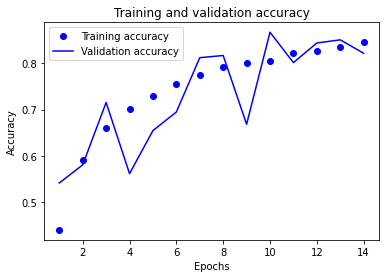

In [ ]:
history_dict = history.history #access the history attribute of the History object
acc_values = history_dict["accuracy"] #access training accuracy
val_acc_values = history_dict["val_accuracy"] # access validation accuracy
epochs = range(1, len(acc_values) +1) # specify number of epochs to visualise
plt.plot(epochs, acc_values, "bo", label="Training accuracy") #plot training accuracy
plt.plot(epochs, val_acc_values, "b", label="Validation accuracy")# plot validation accuracy
plt.title("Training and validation accuracy") #title
plt.xlabel("Epochs") # X label
plt.ylabel("Accuracy") # Y label
plt.legend() # show legend
plt.show() # show plot

The above graph shows a similar pattern. Both of our training and validation accuracy improved until epoch 10, but our validation accuracy stopped improving after epoch 10, telling us that at this point, our model started overfitting. Our callback function was triggered and training was stopped and the best model was saved to disk.

At epoch 10, our validation accuracy was `86.72%` – not bad! This model was saved to disk and can be loaded later to make predictions on new images.

#### Confusion Matrix

A common way to evaluate the performance of a classifier is to look at the confusion matrix. The basic idea is to count the number of times instances of class A are classified as class B.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. We have already done this above using the `model.predict()` function.

To generate confusion matrix, the `confusion_matrix()` function can be used. This function takes a target class (actual labels) and the predicted class (predictions of the model).

Before we can calculate the confusion matrix, we have to prepare our predictions array to feed into the `confusion_matrix()` function.

Recall that the last layer of our model has 10 units and uses a `softmax` activation function. This means the output of our model will be a vector of 10 columns whose values are within 0-1 range, indicating the probability that an observation belongs to one of the 10 classes (the `softmax` activation tranforms the output to a 0-1 range and these values are interpreted as probabilities). For example, the output vector could look like this:

`[0.0,0.1,0.0,0.1,0.01,0.0,0.0,0.79]`

The above means that the probability that the input image belongs to the class 10 is 79%. To generate a confusion matrix, we need to transform this vector to another vector that just holds the indices of the maximum values (highest probability). The function below does this.


In [ ]:
"""
Run helper function to generate two matrices that just hold the indices of the maximum values
i.e., y_test_amax and y_pred_amax will hold the classes that our model think has the highest probability that an input image belong to.
"""
y_test_amax, y_pred_amax = find_indices_with_highest_probability(y_pred, y_test)

#### Import libraries

In [ ]:
from sklearn import metrics # to generate confusion matrix
import pandas as pd # to use pandas DataFrames
import seaborn as sns # seaborn is a visualisation library built ontop of matplotlib

#### Generate confusion matrix

In [ ]:
matrix = metrics.confusion_matrix(y_test_amax, y_pred_amax)
matrix

array([[174,   1,   1,  12,   1,   1,   7,   1,   0,   0],
       [  0, 196,   4,   0,   0,   2,   0,   0,   0,   0],
       [  4,   1, 101,  28,   9,  14,  35,   4,   4,   0],
       [  1,   2,   0, 153,  23,   1,   3,  10,   4,   0],
       [  0,   0,   0,   2, 190,   0,   0,   0,   0,   0],
       [  4,  32,   3,  26,   0,  68,  13,   0,   0,   0],
       [ 13,   0,   3,  18,   1,   1, 116,   0,   0,   0],
       [  0,   0,   0,  10,  32,   0,   0, 164,   0,   0],
       [  0,   0,   0,   1,   1,   0,   0,   0, 167,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2, 224]])

In [ ]:
label_str=[ #converting categorical integers to readable categories
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake' ]


con_mat_df = pd.DataFrame(matrix, #convert confusion matrix to pandas dataframe
                                index  = label_str, #index is labels list defined above
                                columns= label_str) #columns is also labels list define above
con_mat_df

,AnnualCrop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,PermanentCrop,Residential,River,SeaLake
AnnualCrop,174,1,1,12,1,1,7,1,0,0
Forest,0,196,4,0,0,2,0,0,0,0
HerbaceousVegetation,4,1,101,28,9,14,35,4,4,0
Highway,1,2,0,153,23,1,3,10,4,0
Industrial,0,0,0,2,190,0,0,0,0,0
Pasture,4,32,3,26,0,68,13,0,0,0
PermanentCrop,13,0,3,18,1,1,116,0,0,0
Residential,0,0,0,10,32,0,0,164,0,0
River,0,0,0,1,1,0,0,0,167,2
SeaLake,0,0,0,0,0,0,0,0,2,224


#### Visualise the Confusion Matrix

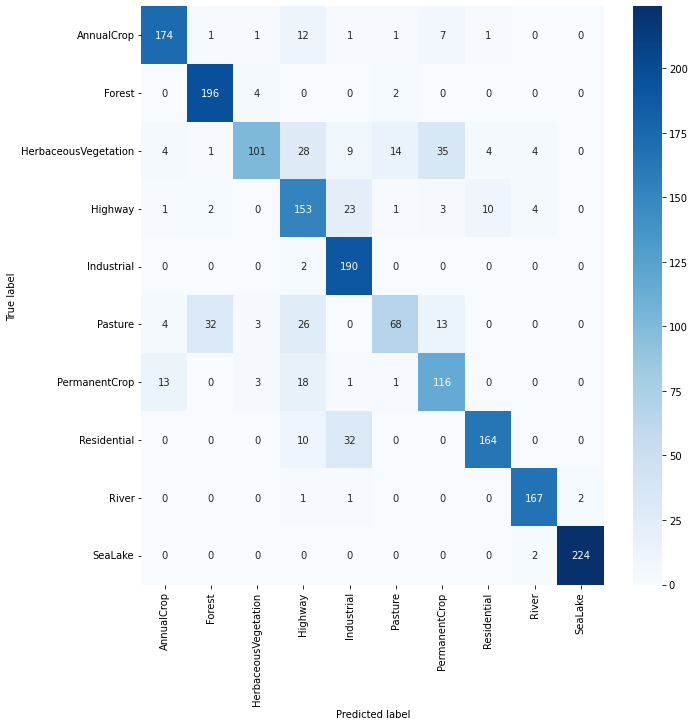

In [ ]:
"""
Plot the confusion matrix using seaborn
"""
plt.figure(figsize=(10, 10)) #initialise a figure
sns.heatmap(con_mat_df, #generate a heatmap from the confusion matrix DataFrame
            annot=True,
            fmt='d',
            cmap=plt.cm.Blues)
plt.tight_layout() #adjust the padding around the figure
plt.ylabel('True label') # Y label
plt.xlabel('Predicted label') # X Label
plt.show() # show plot